# Exploration du Dataset Cityscapes

Ce notebook explore le dataset Cityscapes pour la segmentation semantique d'images de scenes urbaines.

## Objectifs
- Comprendre la structure du dataset
- Visualiser des exemples d'images et leurs masks
- Analyser les 8 categories principales
- Etudier la distribution des classes

## 1. Imports et Configuration

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import Counter
from tqdm import tqdm

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

%matplotlib inline

In [2]:
# Chemins vers les donnees
DATA_DIR = Path('../data')
IMAGES_DIR = DATA_DIR / 'leftImg8bit'
LABELS_DIR = DATA_DIR / 'gtFine'

print(f"Dossier images: {IMAGES_DIR}")
print(f"Dossier labels: {LABELS_DIR}")
print(f"\nImages existe: {IMAGES_DIR.exists()}")
print(f"Labels existe: {LABELS_DIR.exists()}")

Dossier images: ../data/leftImg8bit
Dossier labels: ../data/gtFine

Images existe: True
Labels existe: True


## 2. Structure du Dataset

In [3]:
# Lister les splits disponibles (train, val, test)
splits = [d.name for d in IMAGES_DIR.iterdir() if d.is_dir()]
print(f"Splits disponibles: {splits}")

Splits disponibles: ['test', 'train', 'val']


In [4]:
# Compter les images par split et par ville
def count_images_per_split(images_dir):
    stats = {}
    for split in ['train', 'val', 'test']:
        split_dir = images_dir / split
        if split_dir.exists():
            cities = {}
            for city_dir in split_dir.iterdir():
                if city_dir.is_dir():
                    n_images = len(list(city_dir.glob('*.png')))
                    cities[city_dir.name] = n_images
            stats[split] = cities
    return stats

image_stats = count_images_per_split(IMAGES_DIR)

# Afficher le resume
for split, cities in image_stats.items():
    total = sum(cities.values())
    print(f"\n{split.upper()}: {total} images dans {len(cities)} villes")
    for city, count in sorted(cities.items()):
        print(f"  - {city}: {count} images")


TRAIN: 2975 images dans 18 villes
  - aachen: 174 images
  - bochum: 96 images
  - bremen: 316 images
  - cologne: 154 images
  - darmstadt: 85 images
  - dusseldorf: 221 images
  - erfurt: 109 images
  - hamburg: 248 images
  - hanover: 196 images
  - jena: 119 images
  - krefeld: 99 images
  - monchengladbach: 94 images
  - strasbourg: 365 images
  - stuttgart: 196 images
  - tubingen: 144 images
  - ulm: 95 images
  - weimar: 142 images
  - zurich: 122 images

VAL: 500 images dans 3 villes
  - frankfurt: 267 images
  - lindau: 59 images
  - munster: 174 images

TEST: 1525 images dans 6 villes
  - berlin: 544 images
  - bielefeld: 181 images
  - bonn: 46 images
  - leverkusen: 58 images
  - mainz: 298 images
  - munich: 398 images


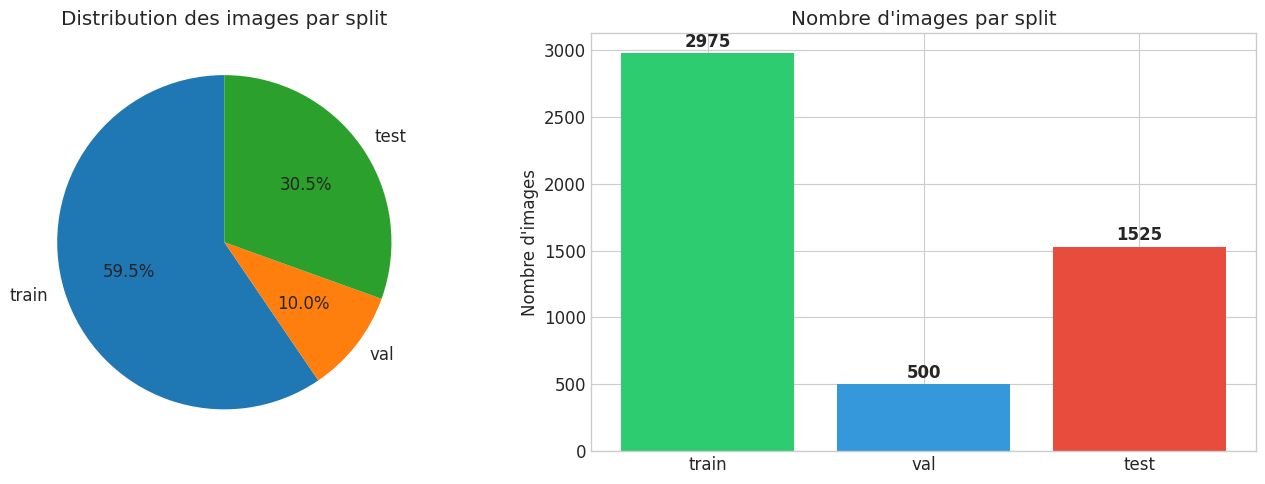

In [5]:
# Visualisation de la distribution des images par split
split_totals = {split: sum(cities.values()) for split, cities in image_stats.items()}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart des splits
axes[0].pie(split_totals.values(), labels=split_totals.keys(), autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribution des images par split')

# Bar chart des splits
axes[1].bar(split_totals.keys(), split_totals.values(), color=['#2ecc71', '#3498db', '#e74c3c'])
axes[1].set_title('Nombre d\'images par split')
axes[1].set_ylabel('Nombre d\'images')

for i, (split, count) in enumerate(split_totals.items()):
    axes[1].text(i, count + 50, str(count), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 3. Types de fichiers d'annotation

In [6]:
# Explorer les fichiers d'annotation pour une image
sample_city = list((LABELS_DIR / 'train').iterdir())[0]
sample_files = list(sample_city.iterdir())[:8]

print(f"Ville exemple: {sample_city.name}")
print(f"\nTypes de fichiers d'annotation:")
for f in sorted(sample_files):
    print(f"  - {f.name}")

Ville exemple: aachen

Types de fichiers d'annotation:
  - aachen_000000_000019_gtFine_color.png
  - aachen_000000_000019_gtFine_instanceIds.png
  - aachen_000000_000019_gtFine_labelIds.png
  - aachen_000000_000019_gtFine_polygons.json
  - aachen_000001_000019_gtFine_color.png
  - aachen_000001_000019_gtFine_instanceIds.png
  - aachen_000001_000019_gtFine_labelIds.png
  - aachen_000001_000019_gtFine_polygons.json


In [7]:
# Explication des types de fichiers
print("Types de fichiers dans Cityscapes gtFine:")
print("="*50)
print("\n1. *_gtFine_color.png")
print("   -> Mask colore pour visualisation humaine")
print("\n2. *_gtFine_labelIds.png")
print("   -> Mask avec IDs de labels (0-33) - UTILISE POUR L'ENTRAINEMENT")
print("\n3. *_gtFine_instanceIds.png")
print("   -> Mask avec IDs d'instances (segmentation d'instances)")
print("\n4. *_gtFine_polygons.json")
print("   -> Annotations au format polygone (JSON)")

Types de fichiers dans Cityscapes gtFine:

1. *_gtFine_color.png
   -> Mask colore pour visualisation humaine

2. *_gtFine_labelIds.png
   -> Mask avec IDs de labels (0-33) - UTILISE POUR L'ENTRAINEMENT

3. *_gtFine_instanceIds.png
   -> Mask avec IDs d'instances (segmentation d'instances)

4. *_gtFine_polygons.json
   -> Annotations au format polygone (JSON)


## 4. Classes Cityscapes - Mapping vers 8 categories

In [8]:
# Definition des 8 categories principales Cityscapes
# Basees sur les groupes officiels du dataset

CITYSCAPES_CATEGORIES = {
    0: {'name': 'void', 'color': (0, 0, 0)},           # Classes ignorees
    1: {'name': 'flat', 'color': (128, 64, 128)},      # road, sidewalk, parking, rail track
    2: {'name': 'construction', 'color': (70, 70, 70)}, # building, wall, fence, guard rail, bridge, tunnel
    3: {'name': 'object', 'color': (153, 153, 153)},   # pole, polegroup, traffic light, traffic sign
    4: {'name': 'nature', 'color': (107, 142, 35)},    # vegetation, terrain
    5: {'name': 'sky', 'color': (70, 130, 180)},       # sky
    6: {'name': 'human', 'color': (220, 20, 60)},      # person, rider
    7: {'name': 'vehicle', 'color': (0, 0, 142)}       # car, truck, bus, caravan, trailer, train, motorcycle, bicycle
}

# Affichage des categories
print("Les 8 categories principales:")
print("="*40)
for cat_id, info in CITYSCAPES_CATEGORIES.items():
    print(f"{cat_id}: {info['name']:15} - RGB{info['color']}")

Les 8 categories principales:
0: void            - RGB(0, 0, 0)
1: flat            - RGB(128, 64, 128)
2: construction    - RGB(70, 70, 70)
3: object          - RGB(153, 153, 153)
4: nature          - RGB(107, 142, 35)
5: sky             - RGB(70, 130, 180)
6: human           - RGB(220, 20, 60)
7: vehicle         - RGB(0, 0, 142)


In [9]:
# Mapping des 34 classes originales vers les 8 categories
# Label IDs originaux -> Category ID

LABEL_TO_CATEGORY = {
    # void (ignore)
    0: 0,   # unlabeled
    1: 0,   # ego vehicle
    2: 0,   # rectification border
    3: 0,   # out of roi
    4: 0,   # static
    5: 0,   # dynamic
    6: 0,   # ground
    # flat
    7: 1,   # road
    8: 1,   # sidewalk
    9: 1,   # parking
    10: 1,  # rail track
    # construction
    11: 2,  # building
    12: 2,  # wall
    13: 2,  # fence
    14: 2,  # guard rail
    15: 2,  # bridge
    16: 2,  # tunnel
    # object
    17: 3,  # pole
    18: 3,  # polegroup
    19: 3,  # traffic light
    20: 3,  # traffic sign
    # nature
    21: 4,  # vegetation
    22: 4,  # terrain
    # sky
    23: 5,  # sky
    # human
    24: 6,  # person
    25: 6,  # rider
    # vehicle
    26: 7,  # car
    27: 7,  # truck
    28: 7,  # bus
    29: 7,  # caravan
    30: 7,  # trailer
    31: 7,  # train
    32: 7,  # motorcycle
    33: 7,  # bicycle
    -1: 0,  # license plate (ignore)
}

print(f"Nombre de classes originales: 34")
print(f"Nombre de categories cibles: 8")

Nombre de classes originales: 34
Nombre de categories cibles: 8


## 5. Visualisation d'exemples

In [10]:
def get_image_label_paths(split='train', city=None, n=1):
    """Recupere les chemins d'images et leurs labels correspondants."""
    split_dir = IMAGES_DIR / split
    
    if city:
        cities = [split_dir / city]
    else:
        cities = list(split_dir.iterdir())
    
    pairs = []
    for city_dir in cities:
        if not city_dir.is_dir():
            continue
        for img_path in city_dir.glob('*.png'):
            # Construire le chemin du label
            city_name = city_dir.name
            img_name = img_path.stem.replace('_leftImg8bit', '')
            
            label_path = LABELS_DIR / split / city_name / f"{img_name}_gtFine_labelIds.png"
            color_path = LABELS_DIR / split / city_name / f"{img_name}_gtFine_color.png"
            
            if label_path.exists():
                pairs.append({
                    'image': img_path,
                    'label': label_path,
                    'color': color_path if color_path.exists() else None,
                    'city': city_name
                })
            
            if len(pairs) >= n:
                return pairs
    
    return pairs

# Test
sample_pairs = get_image_label_paths('train', n=3)
print(f"Trouve {len(sample_pairs)} paires image/label")
for p in sample_pairs:
    print(f"  - {p['city']}: {p['image'].name}")

Trouve 3 paires image/label
  - aachen: aachen_000000_000019_leftImg8bit.png
  - aachen: aachen_000001_000019_leftImg8bit.png
  - aachen: aachen_000002_000019_leftImg8bit.png


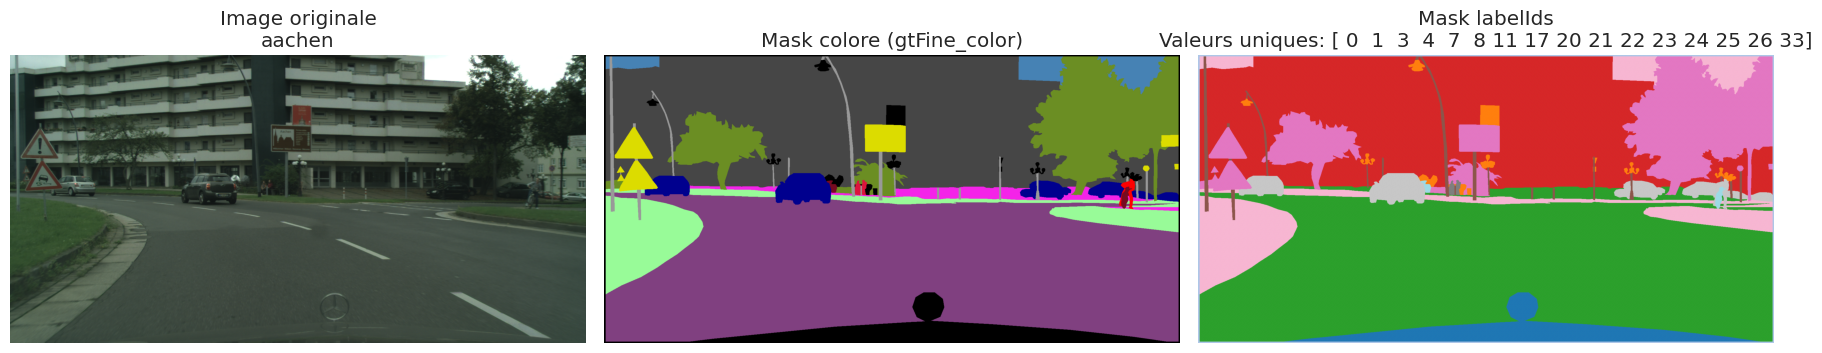

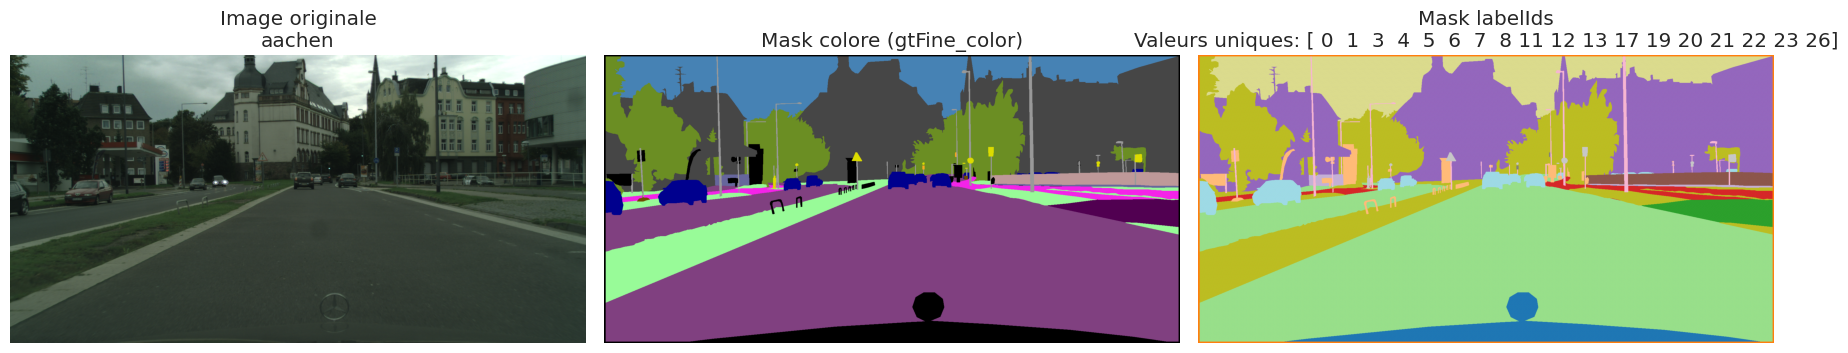

In [11]:
def visualize_sample(pair, figsize=(18, 6)):
    """Visualise une image avec son mask de segmentation."""
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Image originale
    img = Image.open(pair['image'])
    axes[0].imshow(img)
    axes[0].set_title(f"Image originale\n{pair['city']}")
    axes[0].axis('off')
    
    # Mask colore (visualisation officielle)
    if pair['color']:
        color_mask = Image.open(pair['color'])
        axes[1].imshow(color_mask)
        axes[1].set_title('Mask colore (gtFine_color)')
    else:
        axes[1].text(0.5, 0.5, 'Non disponible', ha='center', va='center')
        axes[1].set_title('Mask colore')
    axes[1].axis('off')
    
    # Mask labelIds
    label_mask = np.array(Image.open(pair['label']))
    axes[2].imshow(label_mask, cmap='tab20')
    axes[2].set_title(f'Mask labelIds\nValeurs uniques: {np.unique(label_mask)}')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return img, label_mask

# Visualiser quelques exemples
for pair in sample_pairs[:2]:
    img, mask = visualize_sample(pair)

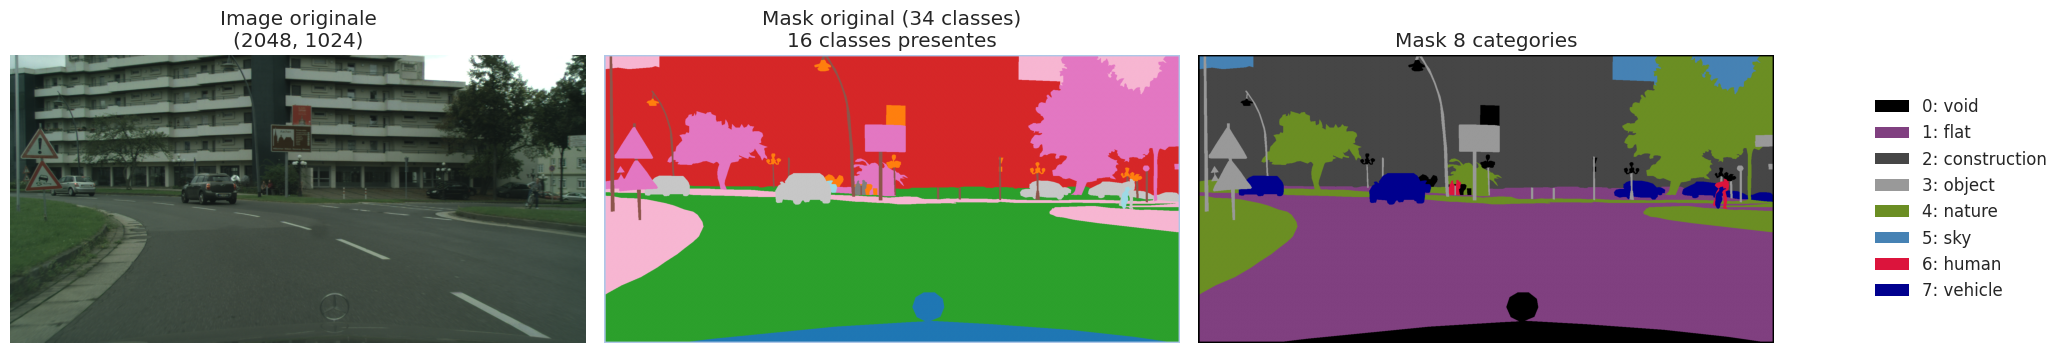

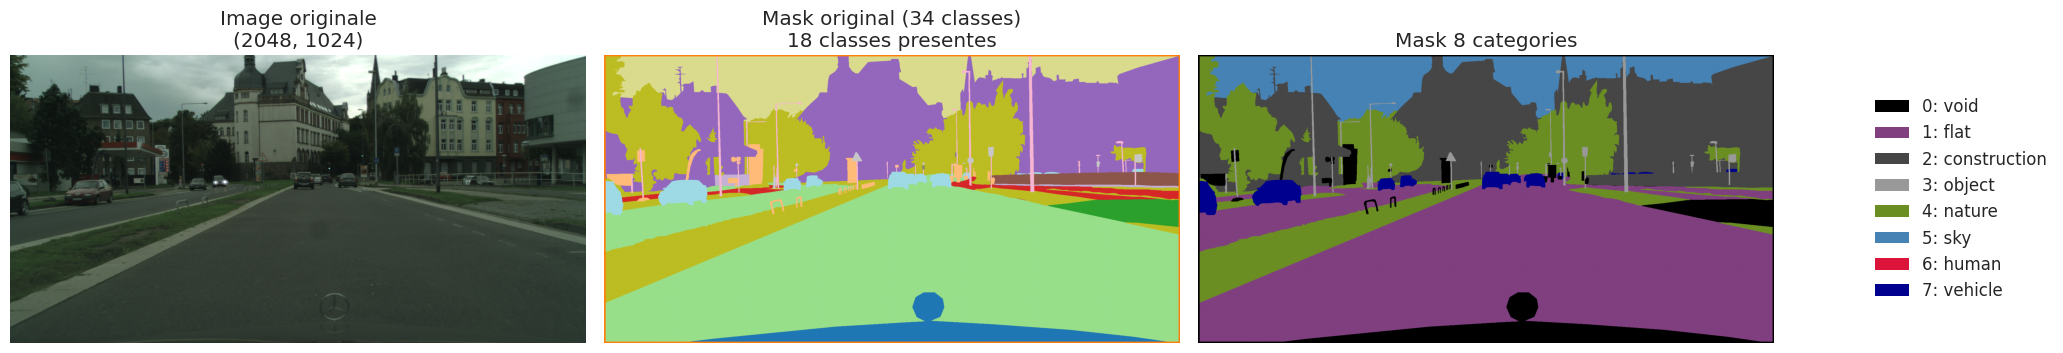

In [12]:
def convert_to_8_categories(label_mask):
    """Convertit un mask de 34 classes vers 8 categories."""
    category_mask = np.zeros_like(label_mask)
    for label_id, cat_id in LABEL_TO_CATEGORY.items():
        if label_id >= 0:
            category_mask[label_mask == label_id] = cat_id
    return category_mask

def create_category_colormap():
    """Cree une colormap pour les 8 categories."""
    colors = np.array([info['color'] for info in CITYSCAPES_CATEGORIES.values()]) / 255.0
    from matplotlib.colors import ListedColormap
    return ListedColormap(colors)

def visualize_8_categories(pair, figsize=(18, 6)):
    """Visualise une image avec son mask converti en 8 categories."""
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Image originale
    img = Image.open(pair['image'])
    axes[0].imshow(img)
    axes[0].set_title(f"Image originale\n{img.size}")
    axes[0].axis('off')
    
    # Mask original (34 classes)
    label_mask = np.array(Image.open(pair['label']))
    axes[1].imshow(label_mask, cmap='tab20')
    axes[1].set_title(f'Mask original (34 classes)\n{len(np.unique(label_mask))} classes presentes')
    axes[1].axis('off')
    
    # Mask converti (8 categories)
    category_mask = convert_to_8_categories(label_mask)
    cmap = create_category_colormap()
    im = axes[2].imshow(category_mask, cmap=cmap, vmin=0, vmax=7)
    axes[2].set_title('Mask 8 categories')
    axes[2].axis('off')
    
    # Legende
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=np.array(info['color'])/255.0, 
                                      label=f"{cat_id}: {info['name']}") 
                       for cat_id, info in CITYSCAPES_CATEGORIES.items()]
    fig.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.15, 0.5))
    
    plt.tight_layout()
    plt.show()
    
    return category_mask

# Visualiser avec les 8 categories
for pair in sample_pairs[:2]:
    cat_mask = visualize_8_categories(pair)

## 6. Analyse de la distribution des classes

In [13]:
def analyze_class_distribution(split='train', n_samples=50):
    """Analyse la distribution des 8 categories sur un echantillon d'images."""
    pairs = get_image_label_paths(split, n=n_samples)
    
    total_pixels = {cat_id: 0 for cat_id in range(8)}
    
    for pair in tqdm(pairs, desc=f"Analyse {split}"):
        label_mask = np.array(Image.open(pair['label']))
        category_mask = convert_to_8_categories(label_mask)
        
        unique, counts = np.unique(category_mask, return_counts=True)
        for cat_id, count in zip(unique, counts):
            total_pixels[cat_id] += count
    
    return total_pixels

# Analyser la distribution sur le train set
distribution = analyze_class_distribution('train', n_samples=100)

# Afficher les resultats
total = sum(distribution.values())
print("\nDistribution des categories (en % de pixels):")
print("="*50)
for cat_id, count in distribution.items():
    pct = count / total * 100
    name = CITYSCAPES_CATEGORIES[cat_id]['name']
    print(f"{cat_id} ({name:12}): {pct:6.2f}% ({count:,} pixels)")

Analyse train: 100%|██████████| 100/100 [00:04<00:00, 20.45it/s]


Distribution des categories (en % de pixels):
0 (void        ):   8.35% (17,517,808 pixels)
1 (flat        ):  39.76% (83,390,229 pixels)
2 (construction):  25.59% (53,670,959 pixels)
3 (object      ):   1.75% (3,663,775 pixels)
4 (nature      ):  13.78% (28,897,884 pixels)
5 (sky         ):   2.66% (5,575,579 pixels)
6 (human       ):   1.12% (2,340,810 pixels)
7 (vehicle     ):   6.99% (14,658,156 pixels)


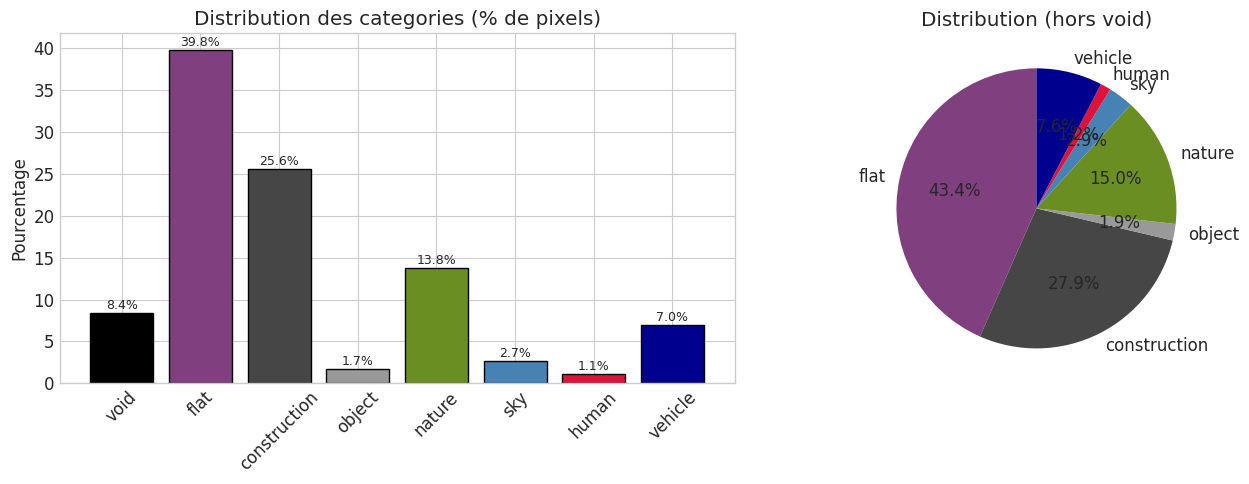

In [14]:
# Visualisation de la distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

categories = [CITYSCAPES_CATEGORIES[i]['name'] for i in range(8)]
colors = [np.array(CITYSCAPES_CATEGORIES[i]['color'])/255.0 for i in range(8)]
values = [distribution[i] for i in range(8)]
percentages = [v/sum(values)*100 for v in values]

# Bar chart
bars = axes[0].bar(categories, percentages, color=colors, edgecolor='black')
axes[0].set_title('Distribution des categories (% de pixels)')
axes[0].set_ylabel('Pourcentage')
axes[0].tick_params(axis='x', rotation=45)

for bar, pct in zip(bars, percentages):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                 f'{pct:.1f}%', ha='center', fontsize=9)

# Pie chart (sans void pour meilleure lisibilite)
non_void_cats = [c for i, c in enumerate(categories) if i != 0]
non_void_colors = [c for i, c in enumerate(colors) if i != 0]
non_void_pcts = [p for i, p in enumerate(percentages) if i != 0]

axes[1].pie(non_void_pcts, labels=non_void_cats, colors=non_void_colors,
            autopct='%1.1f%%', startangle=90)
axes[1].set_title('Distribution (hors void)')

plt.tight_layout()
plt.show()

## 7. Dimensions des images

In [15]:
# Verifier les dimensions des images
sample_pairs = get_image_label_paths('train', n=10)

print("Dimensions des images:")
print("="*50)
for pair in sample_pairs[:5]:
    img = Image.open(pair['image'])
    label = Image.open(pair['label'])
    print(f"Image: {img.size}, Mode: {img.mode}")
    print(f"Label: {label.size}, Mode: {label.mode}")
    print()

Dimensions des images:
Image: (2048, 1024), Mode: RGB
Label: (2048, 1024), Mode: L

Image: (2048, 1024), Mode: RGB
Label: (2048, 1024), Mode: L

Image: (2048, 1024), Mode: RGB
Label: (2048, 1024), Mode: L

Image: (2048, 1024), Mode: RGB
Label: (2048, 1024), Mode: L

Image: (2048, 1024), Mode: RGB
Label: (2048, 1024), Mode: L



In [16]:
# Resume des informations du dataset
print("\n" + "="*60)
print("RESUME DU DATASET CITYSCAPES")
print("="*60)
print(f"\nDimensions images: 2048 x 1024 pixels")
print(f"Format images: PNG RGB")
print(f"Format labels: PNG grayscale (0-33)")
print(f"\nNombre de classes originales: 34")
print(f"Nombre de categories cibles: 8")
print(f"\nSplits:")
for split, total in split_totals.items():
    print(f"  - {split}: {total} images")
print(f"\nTotal: {sum(split_totals.values())} images")
print("\nCategories:")
for cat_id, info in CITYSCAPES_CATEGORIES.items():
    print(f"  {cat_id}: {info['name']}")


RESUME DU DATASET CITYSCAPES

Dimensions images: 2048 x 1024 pixels
Format images: PNG RGB
Format labels: PNG grayscale (0-33)

Nombre de classes originales: 34
Nombre de categories cibles: 8

Splits:
  - train: 2975 images
  - val: 500 images
  - test: 1525 images

Total: 5000 images

Categories:
  0: void
  1: flat
  2: construction
  3: object
  4: nature
  5: sky
  6: human
  7: vehicle


## 8. Considerations pour l'entrainement

### Points importants identifies:

1. **Desequilibre des classes**: La classe `flat` (route, trottoir) et `construction` (batiments) dominent largement
   - Solution: utiliser des poids de classe ou une loss ponderee

2. **Taille des images**: 2048x1024 est tres grand pour l'entrainement
   - Solution: redimensionner (256x128 ou 512x256) ou utiliser des crops

3. **Data augmentation**: essentielle pour ameliorer la generalisation
   - Flip horizontal
   - Rotation legere
   - Changements de luminosite/contraste
   - Random crops

4. **Classe void**: represente les pixels a ignorer pendant l'entrainement

In [17]:
# Calculer les poids de classe pour gerer le desequilibre
total_pixels = sum(distribution.values())
n_classes = 8

# Poids inverse de la frequence
class_weights = {}
for cat_id, count in distribution.items():
    if count > 0:
        class_weights[cat_id] = total_pixels / (n_classes * count)
    else:
        class_weights[cat_id] = 0

# Normaliser les poids
max_weight = max(class_weights.values())
class_weights_normalized = {k: v/max_weight for k, v in class_weights.items()}

print("Poids de classe suggeres (normalises):")
print("="*50)
for cat_id, weight in class_weights_normalized.items():
    name = CITYSCAPES_CATEGORIES[cat_id]['name']
    print(f"{cat_id} ({name:12}): {weight:.4f}")

Poids de classe suggeres (normalises):
0 (void        ): 0.1336
1 (flat        ): 0.0281
2 (construction): 0.0436
3 (object      ): 0.6389
4 (nature      ): 0.0810
5 (sky         ): 0.4198
6 (human       ): 1.0000
7 (vehicle     ): 0.1597


In [18]:
# Sauvegarder la configuration pour utilisation ulterieure
config = {
    'n_classes': 8,
    'image_size': (2048, 1024),
    'target_size': (256, 128),  # Taille reduite pour l'entrainement
    'categories': {k: v['name'] for k, v in CITYSCAPES_CATEGORIES.items()},
    'class_weights': class_weights_normalized,
    'label_to_category': LABEL_TO_CATEGORY
}

# Afficher la config
print("Configuration pour l'entrainement:")
print(json.dumps(config, indent=2, default=str))

Configuration pour l'entrainement:
{
  "n_classes": 8,
  "image_size": [
    2048,
    1024
  ],
  "target_size": [
    256,
    128
  ],
  "categories": {
    "0": "void",
    "1": "flat",
    "2": "construction",
    "3": "object",
    "4": "nature",
    "5": "sky",
    "6": "human",
    "7": "vehicle"
  },
  "class_weights": {
    "0": 0.13362459504065805,
    "1": 0.028070554884793517,
    "2": 0.04361408932529042,
    "3": 0.6389065922443382,
    "4": 0.08100281667681966,
    "5": 0.4198326308352908,
    "6": 1.0,
    "7": 0.1596933475124702
  },
  "label_to_category": {
    "0": 0,
    "1": 0,
    "2": 0,
    "3": 0,
    "4": 0,
    "5": 0,
    "6": 0,
    "7": 1,
    "8": 1,
    "9": 1,
    "10": 1,
    "11": 2,
    "12": 2,
    "13": 2,
    "14": 2,
    "15": 2,
    "16": 2,
    "17": 3,
    "18": 3,
    "19": 3,
    "20": 3,
    "21": 4,
    "22": 4,
    "23": 5,
    "24": 6,
    "25": 6,
    "26": 7,
    "27": 7,
    "28": 7,
    "29": 7,
    "30": 7,
    "31": 7,
    "32": 7

## Prochaines etapes

1. **Notebook 02**: Preparation des donnees et data generator
2. **Notebook 03**: Architecture du modele (U-Net, DeepLab, etc.)
3. **Notebook 04**: Entrainement et evaluation
4. **Notebook 05**: Data augmentation et optimisation